# Sarcasm Detection in News Headlines

**Model Summary - Sarcasm Detection in News Headlines**

**Architecture Overview**

This project employs a Transfer Learning strategy utilizing the BERT-base (Bidirectional Encoder Representations from Transformers) architecture. The model is trained on the News Headlines Dataset for Sarcasm Detection, curated by Rishabh Misra, which provides high-quality, professional linguistic samples from The Onion and HuffPost.

* The Backbone (BERT):
We leverage a pre-trained BERT-base model as the primary feature extractor. Having been trained on massive corpora (Wikipedia and BookCorpus), the backbone provides a deep understanding of grammatical structures, polysemy, and long-range word dependencies.

* The Classification Head:
A custom deep neural network is integrated on top of the BERT backbone. This head processes the 768-dimensional context vector through a series of dense layers (768 -> 384 -> 1), progressively compressing the linguistic information into a final sarcasm probability score.

**Key Technical Components**

* [CLS] Token Representation: Rather than pooling every word in a headline, the model utilizes the [CLS] (Classification) token. Through the Self-Attention mechanism, this token serves as a global sequence summary, effectively "absorbing" subtle ironic cues from across the entire headline.
  
* Activation & Regularization: To model complex, non-linear patterns inherent in sarcasm, ReLU (Rectified Linear Unit) activation is used between linear layers. To mitigate overfitting and ensure robust generalization, a Dropout rate of 0.3 was implemented, preventing the model from over-relying on specific "noisy" keywords.
* Output Layer: The final output is processed via a Sigmoid activation function, mapping the network’s raw values to a probability distribution between $0$ and $1$ with values below 0.5 classified as 'Not Sarcastic' (0) and values equal to or exceeding 0.5 as 'Sarcastic' (1).

**Training & Evaluation Configuration**

Optimization Suite: The model was optimized using Binary Cross Entropy (BCELoss), the standard objective function for binary classification. We utilized the Adam optimizer with a fine-tuning learning rate of $1e^{-5}$ and a batch size of 16 to maintain stable gradient updates.

Performance Metrics: The training process was conducted over 5 epochs. The model demonstrated high performance and strong generalization, as evidenced by the following metrics:

* Training accuracy - 92.24%
* Testing accuracy - 91.07%


In [52]:
!pip install transformers --quiet

In [53]:
#Importing necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [54]:
#Reading the json file and converting it to a dataframe
#lines=True instructs pandas to process each line as a distinct json object
df = pd.read_json('/kaggle/input/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [55]:
#Check for duplicates
df.duplicated().sum()

np.int64(1)

In [56]:
#Dropping the duplicate rows
df.drop_duplicates(inplace=True)

In [57]:
#Check for null values
df.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [58]:
#Drop the 'article_link' column
df = df.drop('article_link', axis=1)

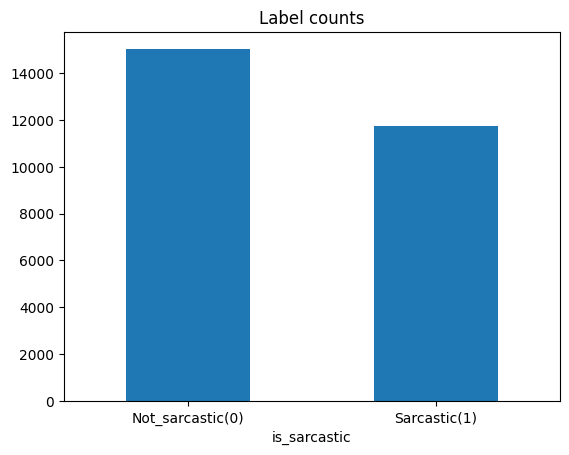

In [60]:
# Plotting the value counts
df['is_sarcastic'].value_counts().plot(kind='bar')

# Correctly setting the x-axis labels
plt.xticks(ticks=[0, 1], labels=['Not_sarcastic(0)', 'Sarcastic(1)'], rotation=0)

plt.title('Label counts')
plt.show()

In [61]:
#Splitting the dataframe ot train, val and test splits
#Convert the dataframe series to numpy arrays
X_train, X_test, y_train, y_test = train_test_split(np.array(df['headline']), np.array(df['is_sarcastic']), test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=42)

In [62]:
print(f' length of train: {X_train.shape[0]} | length of val: {X_val.shape[0]} | length of test: {X_test.shape[0]}')

 length of train: 18695 | length of val: 4006 | length of test: 4007


In [63]:
#Download the tokenizer and the model for bert base uncased
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: google-bert/bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [64]:
#Sample tokenization and embeddings
text = 'I love pizza'

# Convert text to PyTorch tensors ('pt'). This returns a dictionary containing:
# 'input_ids': Numerical indices for each token
# 'attention_mask': 1s for real tokens, 0s for padding
# 'token_type_ids': Used to distinguish between two sentences (not used here)
tokens = tokenizer(text, return_tensors='pt')
print(f'Tokens dictionary: {tokens}')

# Pass the tokens into the BERT model. 
# We use ** to unpack the dictionary (passing input_ids=..., attention_mask=...) 
# so the model receives each key as a separate argument.
output = bert_model(**tokens)

# Extract the 'last_hidden_state' which contains the contextualised embeddings 
# for every token in the sequence from the final transformer layer.
embeddings = output.last_hidden_state 

# Shape will be [1, 5, 768]:
# 1 = Batch size (we processed one sentence)
# 5 = Sequence length ([CLS], I, love, pizza, [SEP])
# 768 = Hidden dimension size for BERT-base
print(f'Shape of embeddings: {embeddings.shape}')
print(f'Embeddings tensor: {embeddings}')

# This line selects the first sentence in the batch [0]
# Then it selects all tokens [:] at the first dimension [0] of the 768 features.
# NOTE: To get the actual [CLS] embedding (often used as a sentence representation), 
# you typically want embeddings[0, 0, :] which is [batch, first_token, all_features].
cls_representation = embeddings[0, 0, :] 
print(f'CLS Token (Sentence) Vector Shape: {cls_representation.shape}')


Tokens dictionary: {'input_ids': tensor([[  101,  1045,  2293, 10733,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}
Shape of embeddings: torch.Size([1, 5, 768])
Embeddings tensor: tensor([[[ 0.1382,  0.3043,  0.0631,  ..., -0.1041,  0.2224,  0.1510],
         [ 0.3200,  0.2953, -0.1416,  ..., -0.2075,  0.8356,  0.2033],
         [ 1.1893,  0.6508,  0.6801,  ...,  0.1086,  0.4138, -0.2404],
         [-0.2060, -0.1327, -0.4286,  ...,  0.3934,  0.2558, -0.2699],
         [ 0.6175,  0.1778, -0.0403,  ...,  0.0127, -0.5838, -0.3406]]],
       grad_fn=<NativeLayerNormBackward0>)
CLS Token (Sentence) Vector Shape: torch.Size([768])


In [65]:
class MyDataset(Dataset):
    """
    Custom Dataset class for Sarcasm Detection using BERT.
    Handles the conversion of raw text headlines into numerical tensors.
    """
    def __init__(self, texts, labels, tokenizer, max_len=128):
        # Initialize dataset with raw features (texts) and targets (labels)
        self.texts = texts 
        self.labels = labels
        # Store the pre-initialized AutoTokenizer for real-time tokenization
        self.tokenizer = tokenizer
        # Set a fixed sequence length (padding/truncating everything to this size)
        self.max_len = max_len

    def __len__(self):
        # Returns the total number of samples in the dataset
        return len(self.texts)
        
    def __getitem__(self, idx):
        # 1. Retrieve the raw string for the given index
        # Ensure it's a string to avoid errors with non-string data types
        text = str(self.texts[idx])
        
        # 2. Convert raw text to token IDs and Attention Masks
        # add_special_tokens: Adds [CLS] at the start and [SEP] at the end
        # padding='max_length': Ensures all tensors in the batch have the same size
        # truncation=True: Cuts off text longer than max_len
        # return_tensors='pt': Returns PyTorch tensors directly
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # 3. Prepare the dictionary of features for the model
        # .flatten() is used to convert the tensor from [1, max_len] to [max_len]
        # This allows the DataLoader to stack them into [batch_size, max_len]
        inputs = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        
        # 4. Prepare the target label
        # BCE loss requires labels to be float32 for mathematical precision
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        # Return a tuple (features, label) to match the unpacked loop (inputs, labels = data)
        return inputs, label

In [66]:
# Pass X_train and y_train directly since they are already Numpy arrays
train_set = MyDataset(X_train, y_train,tokenizer=tokenizer)
val_set = MyDataset(X_val, y_val,tokenizer=tokenizer)
test_set = MyDataset(X_test, y_test, tokenizer=tokenizer)

In [67]:
#Selec the batch size as 16
batch_size = 16
#Initialize train, val and test dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [68]:
# Check if a NVIDIA GPU is available and configured correctly with CUDA.
# If True, 'device' is set to 'cuda' for hardware acceleration.
# If False, it defaults to 'cpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [69]:
class Mymodel(nn.Module):
    def __init__(self, bert):
        super(Mymodel, self).__init__() 

        self.bert = bert
        # Dropout helps prevent overfitting to specific words
        self.dropout = nn.Dropout(0.3)
        
        # BERT base models usually have a hidden size of 768
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 1) # Output 1 for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask, return_dict=False)
        #outputs[0] refers to the last_hidden_state, which is a 3D tensor containing 
        #(batch_size, sequence_length, 768). By using [:, 0], selects the first token (the [CLS] token)
        #for classification rom every headline in the batch.
        pooled_output = outputs[0][:, 0] 
        
        output = self.linear1(pooled_output)
        #Apply ReLU activation to introduce non-linearity
        output = torch.relu(output) 
        #Apply Dropout before the final decision layer.
        output = self.dropout(output)
        output = self.linear2(output)
        #Convert to probability (0.0 = Definitely Not Sarcastic, 1.0 = Definitely Sarcastic).
        output = self.sigmoid(output)
        
        return output

In [70]:
# Unfreeze the last two layers of BERT
# BERT-base has 12 layers (0 to 11)
for name, param in bert_model.named_parameters():
    if "encoder.layer.11" in name or "encoder.layer.10" in name or "pooler" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
model = Mymodel(bert = bert_model).to(device)

In [71]:
#Initialize the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [72]:
epochs = 5
total_train_loss, total_val_loss = [], []
total_train_acc, total_val_acc = [], []

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()
    running_train_loss = 0.0
    total_train_preds = []
    total_train_labels = []
   
    for data in train_loader:
        inputs, labels = data
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        
        # Forward Pass
        # Squeeze(1) removes the extra dimension often added by tokenizers
        outputs = model(inputs['input_ids'].squeeze(1), 
                        inputs['attention_mask'].squeeze(1)).squeeze(1)
        
        loss = criterion(outputs, labels)
        
        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Storing loss for the entire epoch
        running_train_loss += loss.item()
        # For Binary Classification with Sigmoid, round() gives 0 or 1
        preds = outputs.round()
        #Accuracy calculation
        total_train_preds.extend(preds.detach().cpu().numpy())
        total_train_labels.extend(labels.detach().cpu().numpy())

    # --- VALIDATION PHASE ---
    model.eval()
    running_val_loss = 0.0
    total_val_preds = []
    total_val_labels = []
    
    with torch.no_grad():
        for data in val_loader: # Use val_loader here!
            inputs, labels = data
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            # .squeeze(1) is used to align the shapes between the tokenizer output 
            # and the model's expected input dimensions.
            outputs = model(inputs['input_ids'].squeeze(1), 
                            inputs['attention_mask'].squeeze(1)).squeeze(1)
            
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Convert Probabilities to Binary Classifications
            # Since the output is a Sigmoid probability (0 to 1), .round() maps 
            # values < 0.5 to 'Not Sarcastic' (0) and >= 0.5 to 'Sarcastic' (1).
            preds = outputs.round()
            total_val_preds.extend(preds.cpu().numpy())
            total_val_labels.extend(labels.cpu().numpy())

    # --- CALCULATE EPOCH METRICS ---
    # Divide by total batches for loss
    train_loss = running_train_loss / len(train_loader)
    #Calculate accuracy
    train_acc = accuracy_score(total_train_labels, total_train_preds)
    
    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(total_val_labels, total_val_preds)
    
    total_train_loss.append(train_loss)
    total_train_acc.append(train_acc)
    total_val_loss.append(val_loss)
    total_val_acc.append(val_acc)

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}')

Epoch: 01 | Train Loss: 0.3980 | Train Acc: 82.06% | Val Loss: 0.2751 | Val Acc: 88.19%
Epoch: 02 | Train Loss: 0.2775 | Train Acc: 88.19% | Val Loss: 0.2352 | Val Acc: 90.24%
Epoch: 03 | Train Loss: 0.2362 | Train Acc: 90.25% | Val Loss: 0.2197 | Val Acc: 91.21%
Epoch: 04 | Train Loss: 0.2017 | Train Acc: 91.91% | Val Loss: 0.2102 | Val Acc: 91.54%
Epoch: 05 | Train Loss: 0.1824 | Train Acc: 92.73% | Val Loss: 0.2029 | Val Acc: 92.24%


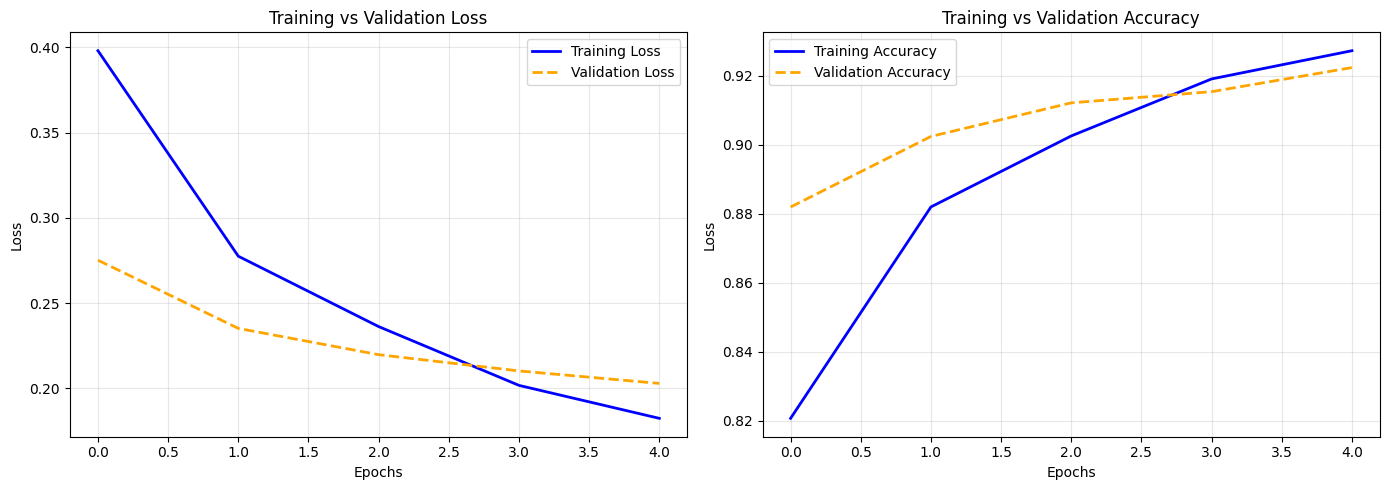

In [73]:
# Create a figure with two subplots
plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
plt.plot(total_train_loss, label='Training Loss', color='blue', lw=2)
plt.plot(total_val_loss , label='Validation Loss', color='orange', lw=2, linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(total_train_acc, label='Training Accuracy', color='blue', lw=2)
plt.plot(total_val_acc , label='Validation Accuracy', color='orange', lw=2, linestyle='--')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [74]:
#Set the model to evaluation mode
model.eval()
# Initialize accumulators for metrics
running_test_loss = 0.0
total_preds = []
total_labels = []

#Disable gradient calculation
with torch.no_grad():
    for idx, data in enumerate(test_loader):
        inputs, labels = data
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        
        # Forward pass
        # .squeeze(1) is used to align the shapes between the tokenizer output 
        # and the model's expected input dimensions.
        outputs = model(inputs['input_ids'].squeeze(1), 
                        inputs['attention_mask'].squeeze(1)).squeeze(1)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        
        # Get predictions (round sigmoid output to 0 or 1)
        preds = outputs.round()
        
        # Store for accuracy_score
        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

# --- CALCULATE FINAL METRICS ---
test_loss = running_test_loss / len(test_loader) 
test_acc = accuracy_score(total_labels, total_preds)

print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%}')

Test Loss: 0.2262 | Test Acc: 91.07%


In [80]:
#Custom function to predict sarcasm
def predict_sarcasm(headline, model, tokenizer, device, max_len=128):
    model.eval() # Set to evaluation mode
    
    # Preprocess and Tokenize
    encoding = tokenizer(
        headline,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Move to Device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    #  Predict
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        # Since we use Sigmoid, output is a probability (0.0 to 1.0)
        prob = output.item()
        prediction = "Sarcastic" if prob > 0.5 else "Not Sarcastic"
        
    return prediction, prob

# --- TEST IT OUT ---
my_headlines = [
    "Local genius spends 4 hours fixing a $5 toaster",
    "Federal Reserve Increases Interest Rates To Combat Inflation",
    "Self-Help Author Dies Of Stress.",
    "New Study Finds 100% Of People Who Die Were Once Alive.",
    "Trump to Travel with Own Escalator Following UN Embarrassment" ]

print("-" * 30)
for h in my_headlines:
    label, _ = predict_sarcasm(h, model, tokenizer, device)
    print(f"Headline: {h}")
    print(f"Result: {label})")
    print("-" * 30)

------------------------------
Headline: Local genius spends 4 hours fixing a $5 toaster
Result: Sarcastic)
------------------------------
Headline: Federal Reserve Increases Interest Rates To Combat Inflation
Result: Not Sarcastic)
------------------------------
Headline: Self-Help Author Dies Of Stress.
Result: Sarcastic)
------------------------------
Headline: New Study Finds 100% Of People Who Die Were Once Alive.
Result: Sarcastic)
------------------------------
Headline: Trump to Travel with Own Escalator Following UN Embarrassment
Result: Sarcastic)
------------------------------
